In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_sparse_clust_cos_glm import Sub_Sparse_Clust_Cos_GLM

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)
print(e_idx.size())
print(i_idx.size())

torch.Size([299])
torch.Size([8])


In [3]:
T_train = 995 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 4
#E_no = 2000
#I_no = 200
E_no = 299
I_no = 8
T_no = 500
device = torch.device("cuda")

batch_length = 50000
batch_size = 5
iter_no = 9950*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Sub_Sparse_Clust_Cos_GLM(sub_no, E_no, I_no, T_no, H_no, device)
syn_params = []
rest_params = []

for name, params in model.named_parameters():
    if (name == "C_syn_e_raw") or (name == "C_syn_i_raw"):
        syn_params.append(params)
        print(name)
    else:
        rest_params.append(params)
        print("NOT", name)

optimizer = torch.optim.Adam(rest_params, lr = 0.005)
syn_optimizer = torch.optim.Adam(syn_params, lr = 0.00025)

#syn_scheduler = torch.optim.lr_scheduler.StepLR(syn_optimizer, step_size=50, gamma=0.97)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

NOT E_scale
NOT I_scale
NOT W_e_layer1
NOT W_i_layer1
NOT W_layer2
NOT b_layer1
C_syn_e_raw
C_syn_i_raw
NOT V_o
1936


In [6]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

score_list = []
rad_max = np.round(np.sqrt((sub_no-1)/sub_no**2 + (1-1/sub_no)**2), 4)
rad_list = np.linspace(0,rad_max,5000)
rad_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    syn_optimizer.zero_grad()
    
    if (rad_count < 4999):
        rad_count += 1
    rad = rad_list[rad_count]
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    #V_pred, _, _ = model(batch_E_neural[:,:,:], batch_I_neural[:,:,:], rad, False)
    V_pred, _, _ = model(batch_E_neural[:,:,e_idx], batch_I_neural[:,:,i_idx], rad, False)
    loss = torch.mean((V_pred - batch_V[:,:])**2)
    
    loss.backward()
    optimizer.step()
    syn_optimizer.step()
    #syn_scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #test_V_pred, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0)[:,:,:], test_I_neural.unsqueeze(0)[:,:,:], -1, True)
        test_V_pred, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0)[:,:,e_idx], test_I_neural.unsqueeze(0)[:,:,i_idx], -1, True)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[:].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list.append(test_score)
        
        #C_syn_idx = torch.argmax(test_C_syn_e[:,880:1120], 0).float()
        C_syn_idx = torch.argmax(test_C_syn_e, 0).float()
                        
        """   
        print(i, np.round(test_score,6),
              np.round(torch.mean(C_syn_idx[:60]).item(), 4),
             np.round(torch.mean(C_syn_idx[60:120]).item(), 4),
             np.round(torch.mean(C_syn_idx[120:180]).item(), 4),
             np.round(torch.mean(C_syn_idx[180:240]).item(), 4))
        print(np.round(torch.var(C_syn_idx[:60]).item(), 4),
             np.round(torch.var(C_syn_idx[60:120]).item(), 4),
             np.round(torch.var(C_syn_idx[120:180]).item(), 4),
             np.round(torch.var(C_syn_idx[180:240]).item(), 4))
        print("------------------------")
        """
        print(i, np.round(test_score,6),
              np.round(rad, 4),
              np.round(torch.mean(C_syn_idx[29:89]).item(), 4),
             np.round(torch.mean(C_syn_idx[89:149]).item(), 4),
             np.round(torch.mean(C_syn_idx[149:209]).item(), 4),
             np.round(torch.mean(C_syn_idx[209:269]).item(), 4))
        print(np.round(torch.var(C_syn_idx[29:89]).item(), 4),
             np.round(torch.var(C_syn_idx[89:149]).item(), 4),
             np.round(torch.var(C_syn_idx[149:209]).item(), 4),
             np.round(torch.var(C_syn_idx[209:269]).item(), 4))
        print("------------------------")

0 0.100613 0.0002 1.35 1.3667 1.6833 1.4667
1.35 1.2192 1.3726 1.5412
------------------------
49 0.183506 0.0087 1.3 1.3833 1.6667 1.4667
1.3322 1.1556 1.3785 1.5412
------------------------
99 0.190572 0.0173 1.2833 1.3833 1.65 1.4667
1.2912 1.1556 1.3839 1.5412
------------------------
149 0.169382 0.026 1.1667 1.3333 1.6833 1.45
1.1921 1.1412 1.3048 1.5398
------------------------
199 0.151126 0.0346 1.1167 1.3333 1.6833 1.5833
1.1556 1.1412 1.3048 1.5353
------------------------
249 0.144172 0.0433 1.0667 1.3167 1.7 1.6167
1.1141 1.1692 1.2644 1.5285
------------------------
299 0.138584 0.052 1.0167 1.35 1.7167 1.6
1.0675 1.2144 1.2912 1.5322
------------------------
349 0.143674 0.0606 1.0167 1.35 1.7167 1.6
1.0675 1.2144 1.2912 1.5322
------------------------
399 0.124833 0.0693 1.0333 1.3167 1.7333 1.6333
1.0836 1.237 1.2497 1.5582
------------------------
449 0.129827 0.078 1.0667 1.3167 1.5667 1.6333
1.0802 1.2709 1.2328 1.5582
------------------------
499 0.133052 0.0866 1.

4249 0.349259 0.7362 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------
4299 0.348967 0.7449 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------
4349 0.355727 0.7536 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------
4399 0.337733 0.7622 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------
4449 0.353864 0.7709 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------
4499 0.344418 0.7796 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------
4549 0.349913 0.7882 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------
4599 0.350329 0.7969 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------
4649 0.351909 0.8055 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------
4699 0.348224 0.8142 1.9167 0.1333 2.35 2.85
0.654 0.2531 0.9432 0.2314
------------------------



KeyboardInterrupt: 

In [ ]:
# Stalls at 2400

In [7]:
C_syn_plot = np.zeros((E_no))

for e in range(E_no):
    C_syn_plot[e] = torch.argmax(model.C_syn_e_raw[:,e])

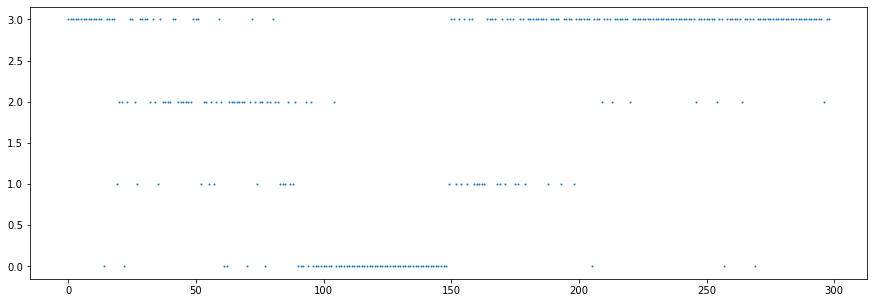

In [8]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), C_syn_plot, s=1)

In [7]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(240), C_syn_plot[880:1120], s=1)

NameError: name 'C_syn_plot' is not defined

<Figure size 1080x360 with 0 Axes>

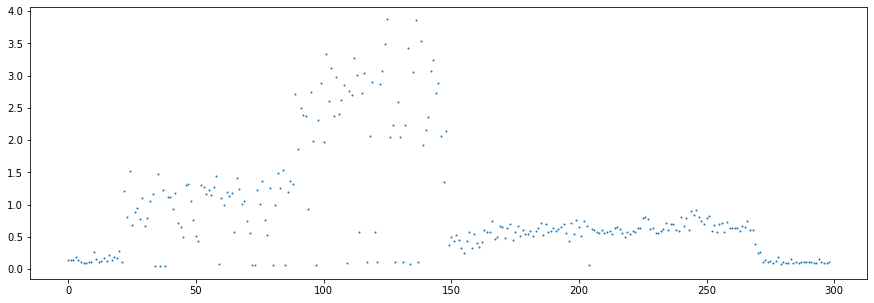

In [10]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), np.exp(model.E_scale.cpu().detach().numpy()), s=1)

In [18]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/glm_diff_clust_s8_h2.pt")

#np.savez("/media/hdd01/sklee/CA1_clust4-60/glm_diff_clust_s8_h2_output.npz",
         test = test_V_pred.cpu().detach().numpy().flatten(),
         kern_e = kern_e,
         kern_i = kern_i,
         scale_e = scale_e,
         scale_i = scale_i,
         C_syn_e = C_syn_e,
         C_syn_i = C_syn_i)